### Import modules

In [1]:
import pandas as pd

from diamondminer.miner import *
from diamondminer import utils

%matplotlib inline

### Load Data

First you need to load your data; here is an example demo dataset.

> Note: Data is assumed to be clean and cropped so that it zooms into diamonds of interest.

In [2]:
# Load the data from the txt file
demo_data_loaded = pd.read_csv('demo_data_1.txt', sep='\t', index_col=0)

# Convert the loaded data back to numpy arrays if needed
P_data = demo_data_loaded.columns.to_numpy().astype(float)
S_data = demo_data_loaded.index.to_numpy().astype(float)
I_data = demo_data_loaded.to_numpy().astype(float)

#### *Optional*: Load from QCoDeS Database

You may want to load from a qcodes database,
```python
db_file = "path/to/qcodes.db"
P_data, S_data, I_data = utils.get_data_from_qcodes_db(
    path_to_db=db_file,
    run_id=41,
    exp_name="exp-name"
)
```

### Extract Diamonds

Next step is to extract the diamonds found in your data. The program does this by,

1. Breaking the data into two halfs: upper and lower.
2. Each half is used as input to the Hough transform.
3. Detected lines are then filtered for any duplicates and are sorted based on which section they belong
and whether their slope is positive or negative.
4. Finally, cluster the relevent lines together and "glue" them together to form our diamonds.

> Note: If the extraction isn't working, turn `debug=True` to plot any intermediate results. 
Adjust parameters found in `miner.filter_raw_data()`, `miner.extract_edges()`, `miner.extract_lines()` until lines are detected.

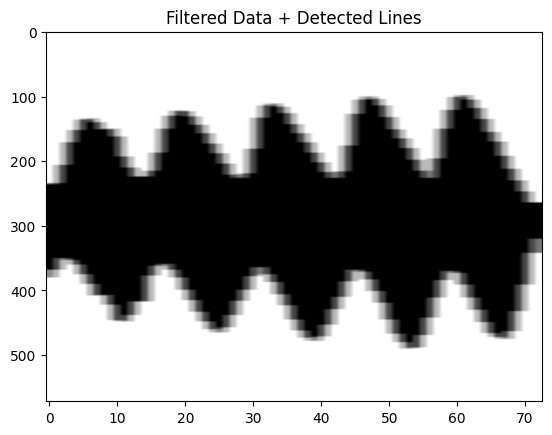

/Users/andrijapaurevic/miniforge3/envs/diamond-miner/lib/python3.10/site-packages/diamondminer/miner.py:166: RuntimeWarning: divide by zero encountered in log
  filtered_current_data = np.log(


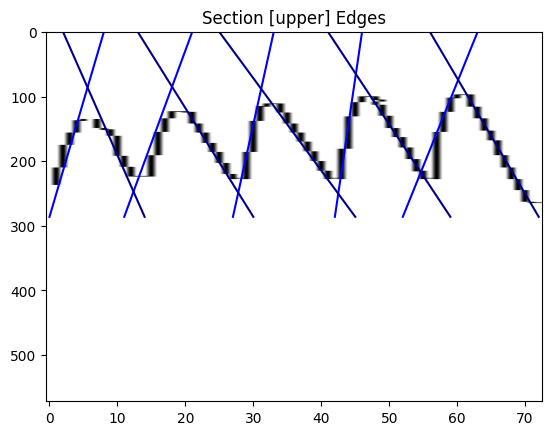

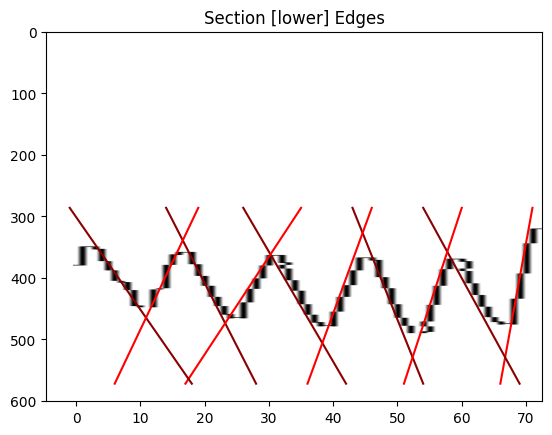

In [3]:
device_voltage_conversion = 1e-3 # Data might have voltage divider connect to source on device
current_sensitivity = 1 # If your data is in volts need to convert using sensitivity

# Can crop by index if desired to isolate diamonds of interest
crop_left = 0 
crop_right = -1

miner = Miner(
    gate_data=P_data[crop_left:crop_right], # Volts
    ohmic_data=S_data[:] * device_voltage_conversion, # Volts
    current_data=I_data[:, crop_left:crop_right] * current_sensitivity, # Ampheres
    # Material properties below are OPTIONAL!
    # They allow for the estimation of dot radius.
    epsR = 3.9, # SiO2
    oxide_thickness = 10e-9, #nm,
    # Tunables for pre-filtering the data
    binary_threshold=1.1, # > 1
    blur_sigma=1.,
    blur_kernel=(3,3),
)
diamonds = miner.extract_diamonds(debug = True)

### Plotting the results!

Summary (#0):


Constants
---------
Elementary Charge (e): 1.60218e-19 C
Permittivity of Free Space (ϵ0): 8.85419e-12 F/m
Relative Permittivity (ϵR): 3.90000
Oxide Thickness: 10.00000 nm
---------


Geometry
---------
Left Vertex: [0.135 0.   ]
Top Vertex: [0.18431507 0.00124476]
Right Vertex: [0.2040411 0.       ]
Bottom Vertex: [ 0.15965753 -0.00140559]
Width: 69.04110 mV
Height: 2.65035 mV
---------


Dot Properties
--------------
Total Lever Arm (α): 0.01919 eV/V
Drain Lever Arm (β): 0.02846 eV/V
Source Lever Arm (γ): 0.06005 eV/V
Addition Voltage: 69.04110 mV
Charging Voltage: 1.32517 mV
Gate Capacitance: 2.32061 aF
Source Capacitance: 38.64248 aF
Drain Capacitance: 79.23299 aF
Total Capacitance: 120.90304 aF
Dot Radius: 105.56914 nm
--------------


Summary (#1):


Constants
---------
Elementary Charge (e): 1.60218e-19 C
Permittivity of Free Space (ϵ0): 8.85419e-12 F/m
Relative Permittivity (ϵR): 3.90000
Oxide Thickness: 10.00000 nm
---------


Geometry
---------
Left Vertex: [0.

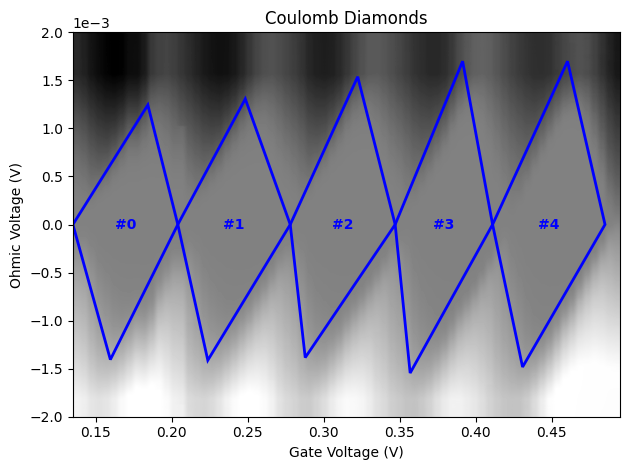

In [4]:
miner.plot_diamonds()

In [5]:
statistics = miner.get_statistics()

Average Lever Arm (α) : 0.02111 eV/V ± 0.00048 eV/V
Average Addition Voltage: 70.02740 mV ± 0.73808 mV
Average Charging Voltage: 1.47203 mV ± 0.02382 mV
Average Total Capacitance: 109.55675 aF ± 1.76995 aF
Average Gate Capacitance: 2.29443 aF ± 0.02471 aF
Average Source Capacitance: 29.91729 aF ± 1.46635 aF
Average Drain Capacitance: 74.60486 aF ± 0.80788 aF
Average Dot Radius: 100.41137 nm ± 0.81239 nm


### Estimate Charge Temperature

Next step is to extract the temperature of your charges based on data found in the Coulomb diamonds. The program does this by,

1. Slicing the data at a specified user ohmic value, $$\vert V_{SD}\vert \leq 200 \mu V$$
2. Fit the Coulomb oscillation to the theoretical function (see supplemental [here](https://pubs.aip.org/aip/apl/article/120/18/184003/2833621/Wafer-scale-low-disorder-2DEG-in-28Si-SiGe-without)),

$$
I(V_G) = A + B \cosh^{-2}\left(\alpha\frac{V_0 - V}{2 k_B T}\right)
$$

where $A, B, V_0$ and $T$ are fit coefficients and $\alpha$ is the lever arm that comes from the Coulomb diamond data.

3. The average temperature is determined by averaging the results from the $N$ detected Coulomb oscillations,

$$
T = \mu_T \pm \frac{\sigma_T}{\sqrt{N}}
$$

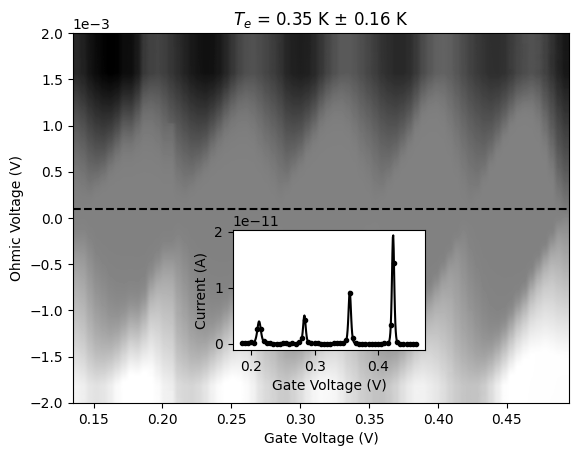

In [6]:
ohmic_value = 100e-6 # Volts

temperatures = miner.estimate_temperatures(
    diamonds, 
    ohmic_value,
    temperature_guess=2
)